=== Classification Report ===
              precision    recall  f1-score   support

        Down       0.83      0.63      0.72       396
          Up       0.76      0.90      0.82       521

    accuracy                           0.78       917
   macro avg       0.79      0.76      0.77       917
weighted avg       0.79      0.78      0.78       917

=== Confusion Matrix ===
[[250 146]
 [ 53 468]]
=== Baseline: Buy-and-Hold Stock Performance ===
Starting capital:     $ 1,000.00
Ending capital:       $ 2,279.74
Total $ growth:       $ 1,279.74
Percentage growth:    127.97%


=== Profitability by Confidence Threshold ===

Threshold: 0.50 | Final: $829.11 | Net P/L: $-170.89 | Trades: 614 | Avg Gain: 0.0180 | Avg Loss: -0.0192
Threshold: 0.60 | Final: $787.85 | Net P/L: $-212.15 | Trades: 454 | Avg Gain: 0.0181 | Avg Loss: -0.0198
Threshold: 0.70 | Final: $984.87 | Net P/L: $-15.13 | Trades: 298 | Avg Gain: 0.0183 | Avg Loss: -0.0185
Threshold: 0.80 | Final: $1,060.81 | Net P/L: $60.8

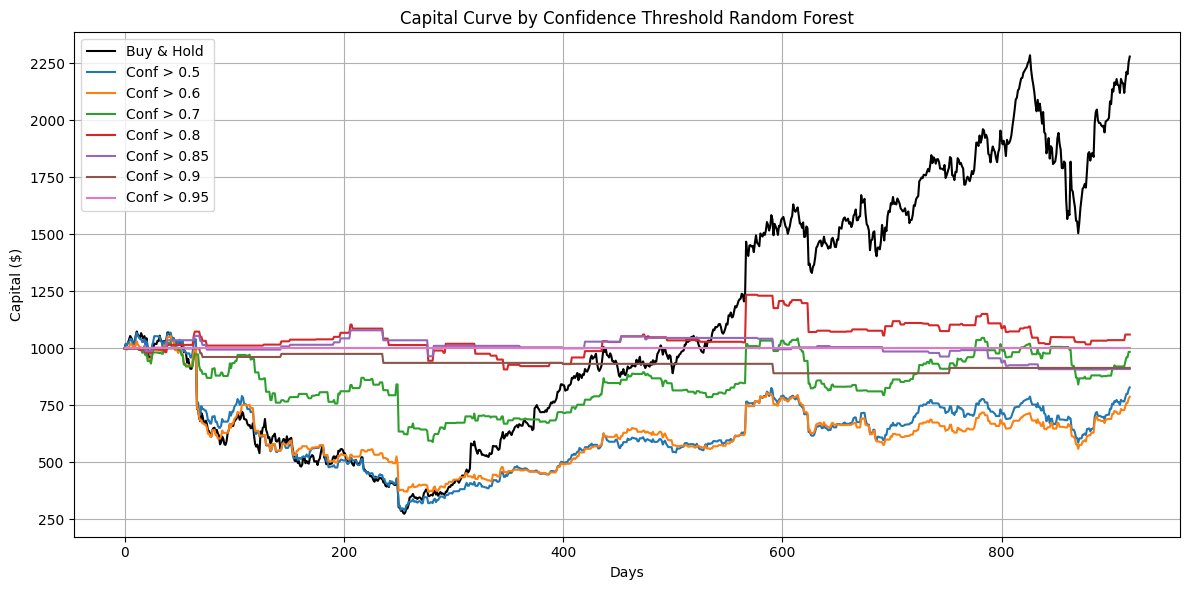

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1) Load ticker data
def load_ticker_windows(ticker, seq_len=30):
    file_path = f"{ticker}_daily_2018-2025.csv"
    if not os.path.exists(file_path):
        df = yf.download(ticker, start="2018-01-01", end="2025-06-30", interval="1d", auto_adjust=True)
        df.to_csv(file_path)
    else:
        df = pd.read_csv(file_path, index_col=0)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)

    df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['BB_MID'] = df['Close'].rolling(20).mean()
    df['BB_STD'] = df['Close'].rolling(20).std()
    df['BB_UP'] = df['BB_MID'] + 2 * df['BB_STD']
    df['BB_DOWN'] = df['BB_MID'] - 2 * df['BB_STD']
    df['ATR'] = (df['High'] - df['Low']).rolling(14).mean()

    df.dropna(inplace=True)

    future_ret = df['log_ret'].rolling(5).sum().shift(-5)
    df['target'] = (future_ret > 0).astype(int)

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'BB_UP', 'BB_DOWN', 'ATR']
    mats, y, dates = [], [], []

    for i in range(seq_len, len(df)):
        mat = df.iloc[i-seq_len:i][features].values
        # No normalization here, just flatten
        mats.append(mat.T.flatten())
        y.append(df['target'].iloc[i])
        dates.append(df.index[i])

    return np.stack(mats), np.array(y), df.iloc[seq_len:].reset_index()

# 2) Load all tickers
X_all, y_all, df_all_list = [], [], []
for ticker in ["AAPL", "MSFT", "GOOG", "AMZN", "META"]:
    X, y, df = load_ticker_windows(ticker)
    X_all.append(X)
    y_all.append(y)
    df_all_list.append(df)

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)
df_all = pd.concat(df_all_list).reset_index(drop=True)

# 3) Train-test split (with shuffle)
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp, shuffle=True)

# 4) Train Random Forest without normalization
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 5) Evaluate
y_pred = rf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))



# 6) Capital simulation across thresholds
probs = rf.predict_proba(X_test)
confidences = np.max(probs, axis=1)
y_pred_conf = np.argmax(probs, axis=1)

returns = np.exp(df_all['log_ret'].values) - 1
test_returns = returns[-len(y_pred_conf):]
initial_capital = 1000.0


# Stock performance over the test period (baseline: buy-and-hold)
stock_capital = initial_capital
stock_curve = [stock_capital]

for ret in test_returns:
    stock_capital *= (1 + ret)
    stock_curve.append(stock_capital)

stock_growth = stock_capital - initial_capital
stock_pct_growth = (stock_capital / initial_capital - 1) * 100

print("=== Baseline: Buy-and-Hold Stock Performance ===")
print(f"Starting capital:     $ {initial_capital:,.2f}")
print(f"Ending capital:       $ {stock_capital:,.2f}")
print(f"Total $ growth:       $ {stock_growth:,.2f}")
print(f"Percentage growth:    {stock_pct_growth:.2f}%\n")

plt.figure(figsize=(12, 6))
plt.plot(stock_curve, label="Buy & Hold", linestyle="-", color="black")

thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]
results = []

for thresh in thresholds:
    capital = initial_capital
    capital_curve = [capital]
    trade_count = 0
    profit_trades, loss_trades = [], []

    for ret, pred, conf in zip(test_returns, y_pred_conf, confidences):
        if pred == 1 and conf > thresh:
            trade_count += 1
            capital *= (1 + ret)
            (profit_trades if ret >= 0 else loss_trades).append(ret)
        capital_curve.append(capital)

    results.append({
        'threshold': thresh,
        'final_capital': capital,
        'net_PL': capital - initial_capital,
        'total_trades': trade_count,
        'avg_gain': np.mean(profit_trades) if profit_trades else 0,
        'avg_loss': np.mean(loss_trades) if loss_trades else 0,
    })

    plt.plot(capital_curve, label=f"Conf > {thresh}")

# 7) Summary print
print("\n=== Profitability by Confidence Threshold ===\n")
for r in results:
    print(f"Threshold: {r['threshold']:.2f} | Final: ${r['final_capital']:,.2f} | "
          f"Net P/L: ${r['net_PL']:,.2f} | Trades: {r['total_trades']} | "
          f"Avg Gain: {r['avg_gain']:.4f} | Avg Loss: {r['avg_loss']:.4f}")

# 8) Plot
plt.title("Capital Curve by Confidence Threshold Random Forest")
plt.xlabel("Days")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



=== Regression MSE ===
0.001120


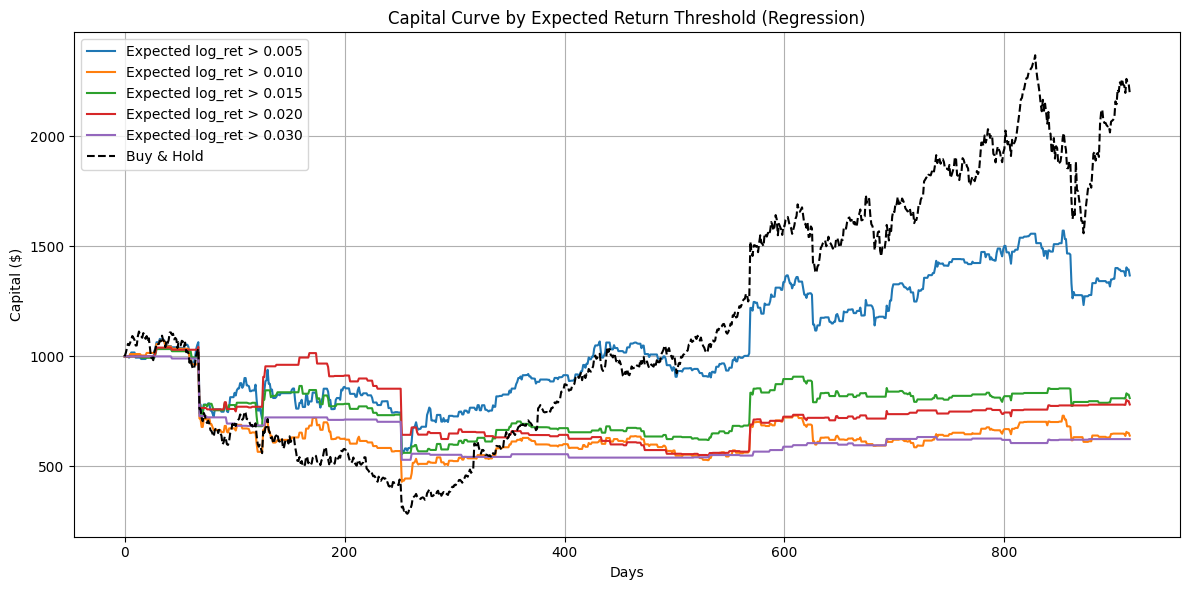


=== Profitability by Expected Log Return Threshold ===

Threshold: 0.005 | Final: $1,367.87 | Net P/L: $367.87 | Trades: 445 | Avg Gain: 0.0202 | Avg Loss: -0.0200
Threshold: 0.010 | Final: $639.94 | Net P/L: $-360.06 | Trades: 287 | Avg Gain: 0.0204 | Avg Loss: -0.0220
Threshold: 0.015 | Final: $810.53 | Net P/L: $-189.47 | Trades: 184 | Avg Gain: 0.0218 | Avg Loss: -0.0238
Threshold: 0.020 | Final: $781.47 | Net P/L: $-218.53 | Trades: 113 | Avg Gain: 0.0231 | Avg Loss: -0.0246
Threshold: 0.030 | Final: $624.20 | Net P/L: $-375.80 | Trades: 38 | Avg Gain: 0.0193 | Avg Loss: -0.0395


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Use the same features and target (future log return) — already calculated in `future_ret`
# Re-load data for regression
def load_ticker_regression(ticker, seq_len=30):
    file_path = f"{ticker}_daily_2018-2025.csv"
    if not os.path.exists(file_path):
        df = yf.download(ticker, start="2018-01-01", end="2025-06-30", interval="1d", auto_adjust=True)
        df.to_csv(file_path)
    else:
        df = pd.read_csv(file_path, index_col=0)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)

    df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['BB_MID'] = df['Close'].rolling(20).mean()
    df['BB_STD'] = df['Close'].rolling(20).std()
    df['BB_UP'] = df['BB_MID'] + 2 * df['BB_STD']
    df['BB_DOWN'] = df['BB_MID'] - 2 * df['BB_STD']
    df['ATR'] = (df['High'] - df['Low']).rolling(14).mean()

    df.dropna(inplace=True)

    # Calculate future return for regression
    df['future_ret'] = df['log_ret'].rolling(5).sum().shift(-5)

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'BB_UP', 'BB_DOWN', 'ATR']
    mats, y, dates = [], [], []

    for i in range(seq_len, len(df) - 5):  # leave room for future return
        mat = df.iloc[i-seq_len:i][features].values
        target = df['future_ret'].iloc[i]  # i aligns with window end
        if pd.notna(target):
            mats.append(mat.T.flatten())
            y.append(target)
            dates.append(df.index[i])

    return np.stack(mats), np.array(y), df.iloc[seq_len:seq_len+len(y)].reset_index()


# Load all tickers again for regression
X_all, y_all, df_all_list = [], [], []
for ticker in ["AAPL", "MSFT", "GOOG", "AMZN", "META"]:
    X, y, df = load_ticker_regression(ticker)
    X_all.append(X)
    y_all.append(y)
    df_all_list.append(df)

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)
df_all = pd.concat(df_all_list).reset_index(drop=True)

# Train/test split
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train)

# Predict
y_pred = rf_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"\n=== Regression MSE ===\n{mse:.6f}")

# Capital Simulation
initial_capital = 1000.0
capital = initial_capital
capital_curve = [capital]

# Get actual test returns
actual_returns = np.exp(df_all['log_ret'].values) - 1
test_returns = actual_returns[-len(y_pred):]

# Define thresholds for trading
expected_log_return_thresholds = [0.005, 0.01, 0.015, 0.02, 0.03]  # ≈ 0.5% to 3%

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
results = []

for thresh in expected_log_return_thresholds:
    capital = initial_capital
    capital_curve = [capital]
    trade_count = 0
    profit_trades, loss_trades = [], []

    for ret, pred_ret in zip(test_returns, y_pred):
        if pred_ret > thresh:
            trade_count += 1
            capital *= (1 + ret)
            (profit_trades if ret >= 0 else loss_trades).append(ret)
        capital_curve.append(capital)

    results.append({
        'threshold': thresh,
        'final_capital': capital,
        'net_PL': capital - initial_capital,
        'total_trades': trade_count,
        'avg_gain': np.mean(profit_trades) if profit_trades else 0,
        'avg_loss': np.mean(loss_trades) if loss_trades else 0,
    })

    plt.plot(capital_curve, label=f"Expected log_ret > {thresh:.3f}")

# Plot baseline
stock_capital = initial_capital
stock_curve = [stock_capital]
for ret in test_returns:
    stock_capital *= (1 + ret)
    stock_curve.append(stock_capital)

plt.plot(stock_curve, label="Buy & Hold", linestyle="-", color="black")

plt.title("Capital Curve by Expected Return Threshold (Regression)")
plt.xlabel("Days")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print summary
print("\n=== Profitability by Expected Log Return Threshold ===\n")
for r in results:
    print(f"Threshold: {r['threshold']:.3f} | Final: ${r['final_capital']:,.2f} | "
          f"Net P/L: ${r['net_PL']:,.2f} | Trades: {r['total_trades']} | "
          f"Avg Gain: {r['avg_gain']:.4f} | Avg Loss: {r['avg_loss']:.4f}")
